# Final Project

Matt Ryder  
Kate Walko  
IST 718  

Goal: Use song lyrics and audio features to identify music genre and predict popularity.

By being able to classify genres and better understand features which belong in similar groups, companies like Spotify can better build their automated playlists and recommender systems.  

According to [Business Insider](https://www.businessinsider.com/how-much-does-spotify-pay-per-stream), "Spotify Popularity gives you a valuable insight into how the Spotify algorithm currently evaluates you and your music. The higher your popularity index, the more likely the algorithm is to recommend you to new listeners, and place you in algorithmic playlists like *Release Radar* and *Discover Weekly*." Since popularity helps put an artists music in front of new listeners it is a very import metric for artists who are compensated based on the amount of listens their music gets. Using analytics and machine learning techniques, this analysis aims to find patterns in music popularity, and explore whether or not recommendations can be made for artists seeking to maximize their musical popularity (and therefore increase streams and ultimately revenue).

In [ ]:
#first - if necessary, mount drive (wd)

from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#create directory
#!mkdir data

#change directory
%cd /datalab/
!pwd

/datalab
/datalab


In [ ]:
#manual upload
#upload the dataset to Colab space
from google.colab import files
uploaded = files.upload()

Saving spotify_songs.csv to spotify_songs.csv


In [ ]:
#import relevant packages
import io
import pandas as pd
import seaborn as sns

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import random

import sklearn
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 

import re, string, unicodedata
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

np.random.seed(666)

## The Data

This dataset contains various types of information over more than 18000 Spotify songs. Song data includes but is not limited to artist, album, audio features (e.g. loudness, acousticness, danceability), lyrics, the language of lyrics, genres, and sub-genres.

The dataset can be downloaded from [Kaggle](https://www.kaggle.com/imuhammad/audio-features-and-lyrics-of-spotify-songs)

In [ ]:
songs = pd.read_csv(io.BytesIO(uploaded['spotify_songs.csv']))

In [ ]:
#importing
#if above method doesn't work - try
#path = "/content/data/spotify_songs.csv"
#songs = pd.read_csv(path, error_bad_lines=False, encoding='utf-8')

In [ ]:
#check out dataframe shape/columns
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18454 entries, 0 to 18453
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  18454 non-null  object 
 1   track_name                18454 non-null  object 
 2   track_artist              18454 non-null  object 
 3   lyrics                    18194 non-null  object 
 4   track_popularity          18454 non-null  int64  
 5   track_album_id            18454 non-null  object 
 6   track_album_name          18454 non-null  object 
 7   track_album_release_date  18454 non-null  object 
 8   playlist_name             18454 non-null  object 
 9   playlist_id               18454 non-null  object 
 10  playlist_genre            18454 non-null  object 
 11  playlist_subgenre         18454 non-null  object 
 12  danceability              18454 non-null  float64
 13  energy                    18454 non-null  float64
 14  key   

In [ ]:
#get an idea of artist names
artists = songs.track_artist.unique()
artists[:50]

array(["Barbie's Cradle", 'Steady Rollin', 'Bell Biv DeVoe',
       'CeeLo Green', 'KARD', 'James TW', 'Diddy', 'Babyface',
       'Blasterjaxx', 'Rocco Hunt', 'Fuego', 'Magic City Hippies',
       'Ricky Martin', '2Pac', 'Reykon', 'Queen', 'Baby Bash',
       'Jax Jones', 'The Weeknd', 'Jay Wheeler', 'Sabrina Carpenter',
       'Zotiyac', 'The Brothers Johnson', 'SAYMYNAME', 'Lil Jon',
       'Foreigner', '2 Chainz', 'MC Breed', 'Joe Arroyo', 'Syn Cole',
       'Manu Chao', 'Sevyn Streeter', 'DREAMCATCHER', 'Confetti', 'PNL',
       'Benjamin Francis Leftwich', 'Louis Tomlinson', 'Sam Feldt',
       'The Jackson 5', 'Calum Scott', 'Eminem', 'Merk & Kremont',
       'Lost Frequencies', 'Tabitha', 'Wisin & Yandel', 'P!nk',
       'Don Omar', 'Dave', 'Lost Kings', 'Lund'], dtype=object)

Text(0.5, 1.0, 'Count of Songs by Lanuages Present in Spotify Dataset')

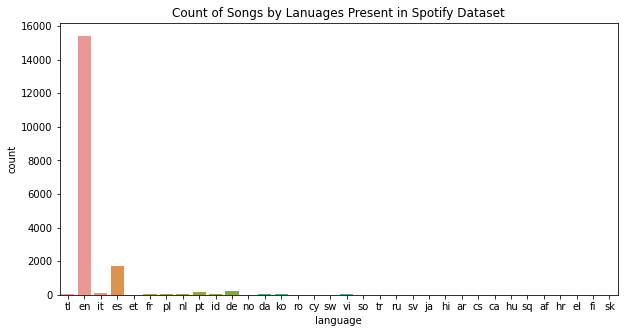

In [ ]:
#checking out the language distribution

fig, ax = plt.subplots(figsize = (10,5))
ax = sns.countplot(x = 'language', data = songs)
plt.title('Count of Songs by Lanuages Present in Spotify Dataset')

In [ ]:
#remove unique IDs for album ID/playlist ID (not needed in this analysis/extraneous label)
songs = songs.drop(columns = ['track_album_id','playlist_id', 'track_id'])

#verify results
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18454 entries, 0 to 18453
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_name                18454 non-null  object 
 1   track_artist              18454 non-null  object 
 2   lyrics                    18194 non-null  object 
 3   track_popularity          18454 non-null  int64  
 4   track_album_name          18454 non-null  object 
 5   track_album_release_date  18454 non-null  object 
 6   playlist_name             18454 non-null  object 
 7   playlist_genre            18454 non-null  object 
 8   playlist_subgenre         18454 non-null  object 
 9   danceability              18454 non-null  float64
 10  energy                    18454 non-null  float64
 11  key                       18454 non-null  int64  
 12  loudness                  18454 non-null  float64
 13  mode                      18454 non-null  int64  
 14  speech

In [ ]:
#after initial EDA - adding this section to remove Korean/Japanese/Chinese
#characters from the data as they blew up regex and they only make up a 
#quite small portion of the overall songs

songs["language"] = songs["language"].astype("category")

#verify results
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18454 entries, 0 to 18453
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   track_name                18454 non-null  object  
 1   track_artist              18454 non-null  object  
 2   lyrics                    18194 non-null  object  
 3   track_popularity          18454 non-null  int64   
 4   track_album_name          18454 non-null  object  
 5   track_album_release_date  18454 non-null  object  
 6   playlist_name             18454 non-null  object  
 7   playlist_genre            18454 non-null  object  
 8   playlist_subgenre         18454 non-null  object  
 9   danceability              18454 non-null  float64 
 10  energy                    18454 non-null  float64 
 11  key                       18454 non-null  int64   
 12  loudness                  18454 non-null  float64 
 13  mode                      18454 non-null  int6

In [ ]:
#songs[~songs.language.str.contains("en", "es", na=False)]
songs_to_drop1 = songs[songs.language != 'en']
songs_to_drop1

#keep the spanish songs for latin genre
spanish_songs = songs[songs.language == 'es']
spanish_songs

#verify results
songs_to_drop1.info()
spanish_songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2789 entries, 0 to 18453
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   track_name                2789 non-null   object  
 1   track_artist              2789 non-null   object  
 2   lyrics                    2789 non-null   object  
 3   track_popularity          2789 non-null   int64   
 4   track_album_name          2789 non-null   object  
 5   track_album_release_date  2789 non-null   object  
 6   playlist_name             2789 non-null   object  
 7   playlist_genre            2789 non-null   object  
 8   playlist_subgenre         2789 non-null   object  
 9   danceability              2789 non-null   float64 
 10  energy                    2789 non-null   float64 
 11  key                       2789 non-null   int64   
 12  loudness                  2789 non-null   float64 
 13  mode                      2789 non-null   int64

In [ ]:
#we'll drop the duplicates and then add the spanish 
#songs back, and reset songs df index

In [ ]:
#first, an inner join to merge the two
duplicates = pd.merge(songs_to_drop1, songs, how='inner',
                  left_on = ['language'], right_on = ['language'],
                  left_index = True)

# drop the matching songs (non-English language)

#songs_test = songs.drop(duplicates.index)
#songs_test.head(10)

songs = songs.drop(duplicates.index)
songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15665 entries, 1 to 18452
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   track_name                15665 non-null  object  
 1   track_artist              15665 non-null  object  
 2   lyrics                    15405 non-null  object  
 3   track_popularity          15665 non-null  int64   
 4   track_album_name          15665 non-null  object  
 5   track_album_release_date  15665 non-null  object  
 6   playlist_name             15665 non-null  object  
 7   playlist_genre            15665 non-null  object  
 8   playlist_subgenre         15665 non-null  object  
 9   danceability              15665 non-null  float64 
 10  energy                    15665 non-null  float64 
 11  key                       15665 non-null  int64   
 12  loudness                  15665 non-null  float64 
 13  mode                      15665 non-null  int6

In [ ]:
#add back the spanish songs to the main songs dataframe
frames = [songs, spanish_songs]

songs = pd.concat(frames)
songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17370 entries, 1 to 18445
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   track_name                17370 non-null  object  
 1   track_artist              17370 non-null  object  
 2   lyrics                    17110 non-null  object  
 3   track_popularity          17370 non-null  int64   
 4   track_album_name          17370 non-null  object  
 5   track_album_release_date  17370 non-null  object  
 6   playlist_name             17370 non-null  object  
 7   playlist_genre            17370 non-null  object  
 8   playlist_subgenre         17370 non-null  object  
 9   danceability              17370 non-null  float64 
 10  energy                    17370 non-null  float64 
 11  key                       17370 non-null  int64   
 12  loudness                  17370 non-null  float64 
 13  mode                      17370 non-null  int6

In [ ]:
#verify only EN and ES present in language now
print(songs.language.unique())

#['en', NaN, 'es'] <- results

['en', NaN, 'es']
Categories (2, object): ['en', 'es']


Dropping non-English songs reduced the total songs count from about 18500 to 15665. We then added back the Spanish songs so we don't lose the entire Latin genre potentially. That leaves about 17K songs. There are also NAs so we need to examine and determine if we should drop them from analysis. If they are all from one genre it may be worth noting.

In [ ]:
#aha - a few NANs in language column - how many?
print(songs['language'].isna().sum())

260


In [ ]:
#where are all the NANs? what columns?
songs.isna().sum()

#There are only NAs in the Lyrics column interestingly.

track_name                    0
track_artist                  0
lyrics                      260
track_popularity              0
track_album_name              0
track_album_release_date      0
playlist_name                 0
playlist_genre                0
playlist_subgenre             0
danceability                  0
energy                        0
key                           0
loudness                      0
mode                          0
speechiness                   0
acousticness                  0
instrumentalness              0
liveness                      0
valence                       0
tempo                         0
duration_ms                   0
language                    260
dtype: int64

In [ ]:
#only in the language column
#separate out the NAs to view
lyrics_nas = songs[songs['language'].isna()]

In [ ]:
#inspect the NAs
lyrics_nas

lyrics_potential_drops = lyrics_nas.value_counts('playlist_genre')

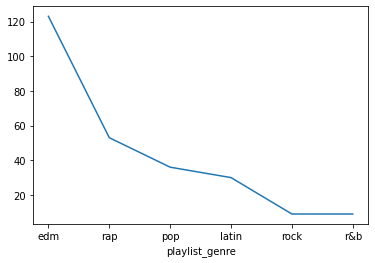

In [ ]:
#examining the NAs - contd

lyrics_potential_drops.plot()

#results indicate we'll be dropping:
#edm      123
#rap       53
#pop       36
#latin     30
#rock       9
#r&b        9

In [ ]:
#drop nan language column records (by keeping only the non-NaN)
songs = songs[songs['language'].notna()]

In [ ]:
#verify only EN present in language now
print(songs.language.unique())

#success!!

['en', 'es']
Categories (2, object): ['en', 'es']


So far we have dropped 260 NA lines all from the Language of the lyrics column, and dropped songs not Spanish or English. Cleaning continues -

In [ ]:
### while reviewing dataset, happened to notice a few lyrics values
###that say "Lyrics for this song have yet to be released"
###We will remove any songs that have this for lyrics.

junk = "Lyrics for this song have yet to be released."

songsjunk = songs.lyrics.str.contains("Lyrics for this song have yet to be released.")
songsjunk.value_counts()
songsjunk

#songs.describe()

1        False
2        False
3        False
4        False
5        False
         ...  
18421    False
18425    False
18427    False
18441    False
18445    False
Name: lyrics, Length: 17110, dtype: bool

In [ ]:
#there are 52 songs per above code results that have this issue 

#repeat the process above for dropping NaN and non-English songs but this time
#drop the "lyrics for this song have yet to be released" songs

In [ ]:
#first, merge the two datasets of songs and songs with the junk error message
invalid_songs = pd.merge(songs, songsjunk, how = 'inner',
                  left_on = ['lyrics'], right_on = ['lyrics'],
                  left_index = True)

# drop the matching songs (invalid lyrics)

songs = songs.drop(invalid_songs.index)
songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17110 entries, 1 to 18445
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   track_name                17110 non-null  object  
 1   track_artist              17110 non-null  object  
 2   lyrics                    17110 non-null  object  
 3   track_popularity          17110 non-null  int64   
 4   track_album_name          17110 non-null  object  
 5   track_album_release_date  17110 non-null  object  
 6   playlist_name             17110 non-null  object  
 7   playlist_genre            17110 non-null  object  
 8   playlist_subgenre         17110 non-null  object  
 9   danceability              17110 non-null  float64 
 10  energy                    17110 non-null  float64 
 11  key                       17110 non-null  int64   
 12  loudness                  17110 non-null  float64 
 13  mode                      17110 non-null  int6

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb80af4ddd0>,
      dtype=object)

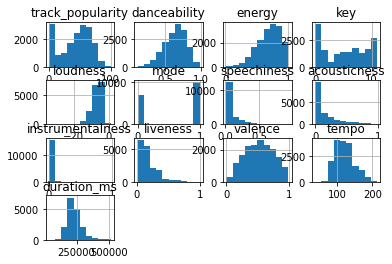

In [ ]:
#finally for now - hist() of all columns to see if anything strange pops out
songs.hist()

In [ ]:
#one small last step, reset songs index now that it's cleaned
songs = songs.reset_index(drop = True)

# Data Preparation

In order to acheive our goals, we need to look at the lyrics and the numeric data sepearately.  First, the data can be cleaned - removing duplicates, erroneous values, etc. Then, the data are split into smaller dataframes which contain only the data specific to each goal for modeling and visualizing.

# Data subsets for viz

In [ ]:
#creating a dataframe of only numerical features + popularity
feature_popularity = songs[['track_popularity','danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms']]
feature_popularity.head()

,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,28,0.303,0.880,9,-4.739,1,0.0442,0.01170,0.00994,0.3470,0.404,135.225,373512
1,0,0.845,0.652,6,-7.504,0,0.2160,0.00432,0.00723,0.4890,0.650,111.904,262467
2,41,0.425,0.378,5,-5.819,0,0.0341,0.68900,0.00000,0.0664,0.405,118.593,243067
3,65,0.760,0.887,9,-1.993,1,0.0409,0.03700,0.00000,0.1380,0.240,130.018,193160
4,70,0.496,0.639,6,-6.157,1,0.0550,0.28000,0.00000,0.0975,0.305,147.764,224720


In [ ]:
#creating a dataframe of only numerical features + genre
feature_genre = songs[['playlist_genre','danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms']]
feature_genre.head()

,playlist_genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,rock,0.303,0.880,9,-4.739,1,0.0442,0.01170,0.00994,0.3470,0.404,135.225,373512
1,r&b,0.845,0.652,6,-7.504,0,0.2160,0.00432,0.00723,0.4890,0.650,111.904,262467
2,r&b,0.425,0.378,5,-5.819,0,0.0341,0.68900,0.00000,0.0664,0.405,118.593,243067
3,pop,0.760,0.887,9,-1.993,1,0.0409,0.03700,0.00000,0.1380,0.240,130.018,193160
4,r&b,0.496,0.639,6,-6.157,1,0.0550,0.28000,0.00000,0.0975,0.305,147.764,224720


In [ ]:
#creating dataframe of only lyrics + popularity 
lyrics_popularity = songs[['track_popularity','lyrics']]
lyrics_popularity.head()

,track_popularity,lyrics
0,28,"The trees, are singing in the wind The sky blu..."
1,0,"NA Yeah, Spyderman and Freeze in full effect U..."
2,41,I really can't stay Baby it's cold outside I'v...
3,65,Get up out of my business You don't keep me fr...
4,70,"Hold your breath, don't look down, keep trying..."


In [ ]:
#creating a dataframe of only lyrics + genre
lyrics_genre = songs[['playlist_genre','lyrics']]
lyrics_genre.head()

,playlist_genre,lyrics
0,rock,"The trees, are singing in the wind The sky blu..."
1,r&b,"NA Yeah, Spyderman and Freeze in full effect U..."
2,r&b,I really can't stay Baby it's cold outside I'v...
3,pop,Get up out of my business You don't keep me fr...
4,r&b,"Hold your breath, don't look down, keep trying..."


## Data Visualization

### Distribution of Popularity

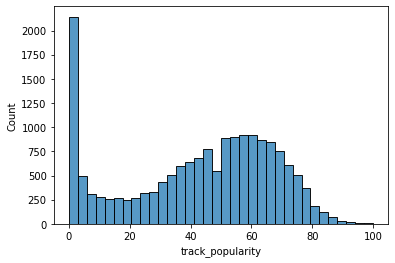

In [ ]:
sns.histplot(data = songs
             , x = 'track_popularity')

While there are a large amount of songs with extremely low (< 10) these values are acceptable as the Spotify algorithm allows for values as low as zero and a decreasing trend in listens will strongly decrease popularity score. For the song which are above 20 the scores are slightly right skewed with mode falling around 60.

### How many different lanuages make up the lyrics values?

There are about 15,000 english songs and nearly 2,000 Spanish songs. A few German songs are also present. 

In [ ]:
#Which artists have the most songs in the dataset?

artist_count = pd.DataFrame(songs.groupby("track_artist")["track_name"].count().sort_values(ascending = False))
artist_count.reset_index(inplace = True)
#let's take the top 25 artists - for graph readability

top25 = artist_count[:25]
top25.columns = ["track_artist", "artist_song_count"]
top25

#artist_count = artist_count.sort_values(by = 'artist_song_count', ascending = False)

,track_artist,artist_song_count
0,Queen,122
1,Don Omar,71
2,David Guetta,70
3,Drake,65
4,Logic,63
5,Guns N' Roses,63
6,The Chainsmokers,59
7,Martin Garrix,52
8,2Pac,51
9,The Weeknd,49


Text(0, 0.5, 'Artist/Musician')

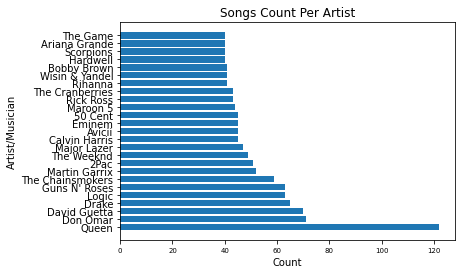

In [ ]:
#create a barplot of the above just to see visually
plt.barh(top25['track_artist'].str.replace('\$\$','\\$\\$'), top25['artist_song_count'])
plt.xticks(fontsize = 7)
plt.title("Songs Count Per Artist")
plt.xlabel("Count")
plt.ylabel("Artist/Musician")

*Queen* has 122 songs in the dataset and ranks #1 by song quantity. David Guetta and Don Omar follow, with about 70 songs. Martin Garrix rounds out the #3 spot.

In [ ]:
#what genres and subgenres exist? 
genreslist = songs.playlist_genre.unique()
genreslist

subgenrelist = songs.playlist_subgenre.unique()
subgenrelist

array(['hard rock', 'new jack swing', 'neo soul', 'dance pop',
       'urban contemporary', 'big room', 'indie poptimism',
       'gangster rap', 'album rock', 'hip pop', 'post-teen pop', 'trap',
       'southern hip hop', 'electropop', 'tropical',
       'progressive electro house', 'pop edm', 'latin hip hop', 'hip hop',
       'permanent wave', 'classic rock', 'electro house', 'latin pop',
       'reggaeton'], dtype=object)

In [ ]:
#create a copy of songs in case Colab disconnects again - don't have to reupload
#the massive CSV again

#then create a bar chart showing the songs info
#songsplot = songs.copy()
#songsplot.info()

### How many songs belong to each genre and subgenre?

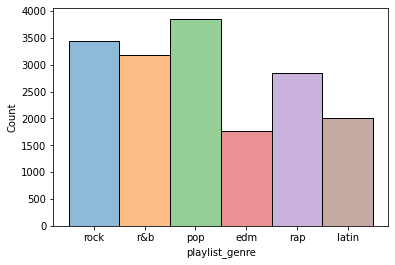

In [ ]:
sns.histplot(data = songs
             , x = 'playlist_genre'
             , hue = 'playlist_genre'
             , legend = False)

Looking at the above histogram, rock, r&b, and rap each make up about 3500 songs in our dataset.  Edm and latin are slightly smaller genres with only about 2000 each.  Pop then makes up the rest of the data with approximately 4000 pop songs in the dataset.

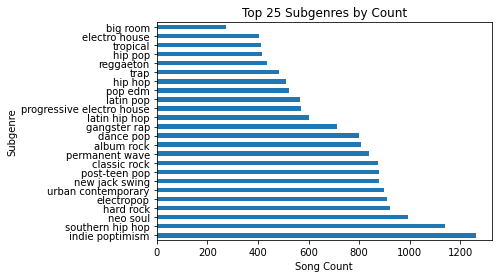

In [ ]:
#what does a plot of subenre look like?

songs['playlist_subgenre'].value_counts().head(25).plot(kind = 'barh')

plt.title('Top 25 Subgenres by Count')
plt.xlabel('Song Count')
plt.ylabel('Subgenre')
plt.show()

### What genres are most popular? 

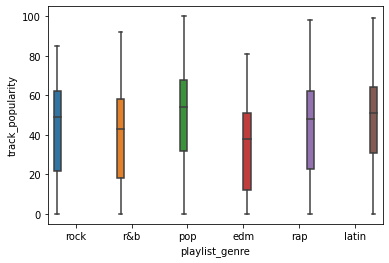

In [ ]:
sns.boxplot(data = songs
            , x = 'playlist_genre'
            , y = 'track_popularity'
            , hue = 'playlist_genre').legend([],[], frameon = False)

All 6 genres in this dataset have similar distributions. The mean popularity of 'pop' is slightly higher than the rest, which would be expected, and 'edm' has the lowest average popularity songs.

### What features are highly correlated with popularity?

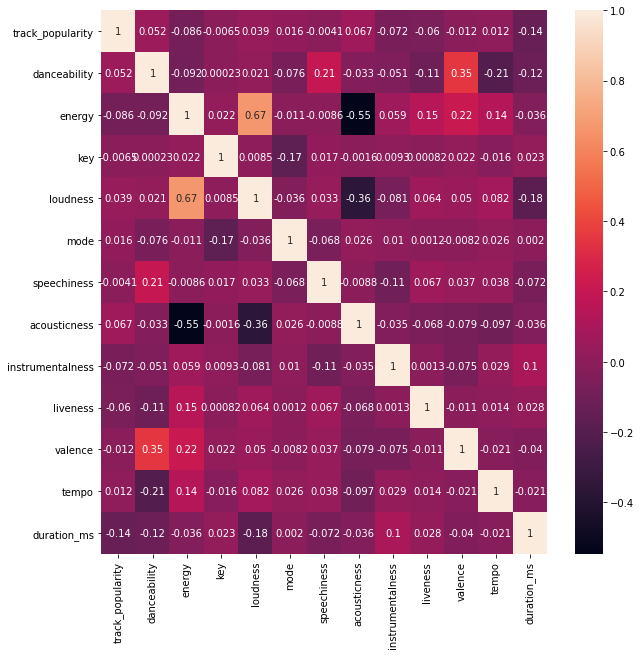

In [ ]:
#Overall correlations: a detailed seaborn correlation plot
plt.figure(figsize = (10,10))
sns.heatmap(songs.corr(), annot = True)

Looking at the heatmap above, no audio features in our dataset have a strong correlation with popularity. The strongest relationships between features are between loudness and energy, and acousticness and energy.

## Using Audio Features to Determine Popularity  

In [ ]:
feature_popularity_train, feature_popularity_test = train_test_split(feature_popularity, test_size = 0.2)

feature_popularity_trainX = feature_popularity_train[['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms']]
feature_popularity_testX = feature_popularity_test[['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms']]

### Ordinary Linear Regression

In [ ]:
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
feature_model = 'track_popularity ~ danceability + energy + key + loudness + mode + speechiness + acousticness + instrumentalness + liveness + valence + tempo + duration_ms'

feature_lm = smf.ols(feature_model, data = feature_popularity).fit()

print(feature_lm.summary())

                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     63.45
Date:                Wed, 16 Jun 2021   Prob (F-statistic):          9.60e-152
Time:                        19:23:53   Log-Likelihood:                -78832.
No. Observations:               17110   AIC:                         1.577e+05
Df Residuals:                   17097   BIC:                         1.578e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           70.8739      2.348  

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

In [ ]:
feature_rf = rf.fit(feature_popularity_trainX, feature_popularity_train['track_popularity'])

In [ ]:
feature_popularity_rfpredicitons = feature_rf.predict(feature_popularity_testX)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print('Mean Squared Error: ', mean_squared_error(feature_popularity_test['track_popularity'], feature_popularity_rfpredicitons))
print('R-Squared: ', r2_score(feature_popularity_test['track_popularity'], feature_popularity_rfpredicitons))

Mean Squared Error:  613.647207652417
R-Squared:  -0.014198045222419964


### Multilayer Perceptron

In [ ]:
from sklearn.neural_network import MLPRegressor

mlpr = MLPRegressor()

In [ ]:
feature_mlpr = mlpr.fit(feature_popularity_trainX, feature_popularity_train['track_popularity'])

In [ ]:
feature_popularity_MLP_predicitons = feature_mlpr.predict(feature_popularity_testX)

In [ ]:
print('Mean Squared Error: ', mean_squared_error(feature_popularity_test['track_popularity'], feature_popularity_MLP_predicitons))
print('R-Squared: ', r2_score(feature_popularity_test['track_popularity'], feature_popularity_MLP_predicitons))

Mean Squared Error:  671.5887912015997
R-Squared:  -0.10996030086354391


## Using Audio Features to Predict Genre

In [ ]:
feature_genre_train, feature_genre_test = train_test_split(feature_genre, test_size = 0.2)

feature_genre_trainX = feature_genre_train[['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms']]
feature_genre_testX = feature_genre_test[['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms']]

### K-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
feature_knn = KNeighborsClassifier(n_neighbors=9)

In [ ]:
feature_knn.fit(feature_genre_trainX, feature_genre_train['playlist_genre'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

In [ ]:
feature_knn_pred = feature_knn.predict(feature_genre_testX)

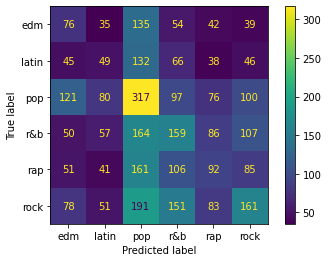

In [ ]:
feature_knn_cm = confusion_matrix(feature_genre_test['playlist_genre'], feature_knn_pred, labels=feature_knn.classes_)
feature_knn_cm_display = ConfusionMatrixDisplay(confusion_matrix = feature_knn_cm, display_labels = feature_knn.classes_)
feature_knn_cm_display.plot(values_format = '.5g')

In [ ]:
feature_knn_score = feature_knn.score(feature_genre_testX, feature_genre_test['playlist_genre'])
print("Accuracy =", feature_knn_score)

Accuracy = 0.24956165984804207


### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
feature_nb = GaussianNB()

In [ ]:
feature_nb.fit(feature_genre_trainX, feature_genre_train['playlist_genre'])

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
feature_nb_pred = feature_nb.predict(feature_genre_testX)

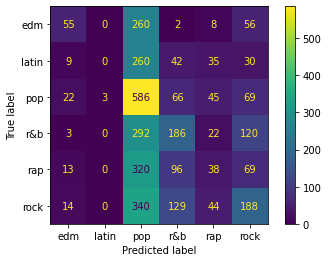

In [ ]:
feature_nb_cm = confusion_matrix(feature_genre_test['playlist_genre'], feature_nb_pred, labels=feature_nb.classes_)
feature_nb_cm_display = ConfusionMatrixDisplay(confusion_matrix = feature_nb_cm, display_labels = feature_nb.classes_)
feature_nb_cm_display.plot(values_format = '.5g')

In [ ]:
feature_nb_score = feature_nb.score(feature_genre_testX, feature_genre_test['playlist_genre'])
print("Accuracy =", feature_nb_score)

Accuracy = 0.3077147866744594


### Support Vector Machines

In [ ]:
from sklearn.svm import SVC

In [ ]:
feature_svc = SVC()

In [ ]:
feature_svc.fit(feature_genre_trainX, feature_genre_train['playlist_genre'])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
feature_svc_pred = feature_svc.predict(feature_genre_testX)

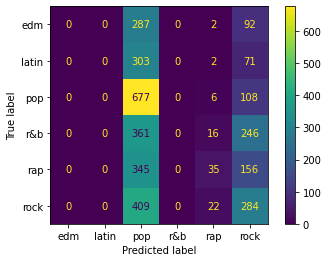

In [ ]:
feature_svc_cm = confusion_matrix(feature_genre_test['playlist_genre'], feature_svc_pred, labels=feature_svc.classes_)
feature_svc_cm_display = ConfusionMatrixDisplay(confusion_matrix = feature_svc_cm, display_labels = feature_svc.classes_)
feature_svc_cm_display.plot(values_format = '.5g')

In [ ]:
feature_svc_score = feature_svc.score(feature_genre_testX, feature_genre_test['playlist_genre'])
print("Accuracy =", feature_svc_score)

Accuracy = 0.2910578609000584


# **Song Lyrics - Cleaning/Preparation**:
NLTK, Pandas and Regex methods to 

*   Clean text - review then remove if beneficial punctuation  and odd characters;
*   Explore and remove stopwords;
*   Append the final clean lyrics back to the Pandas dataframe

Then:

*   Word Cloud(s) (hopefully can add by genre)
*   Sentiment analysis by genre

Then: 
TF-IDF Vectorizer -> regression/MNB, etc. (genre/popularity predicted x sentiment)

###Taking a Subset of Data

In [ ]:
#let's take a subset of the data to make cleaning/viz easier at first
samplesongs = lyrics_genre.sample(n=1000)
#samplesongs.dropna(inplace = True)

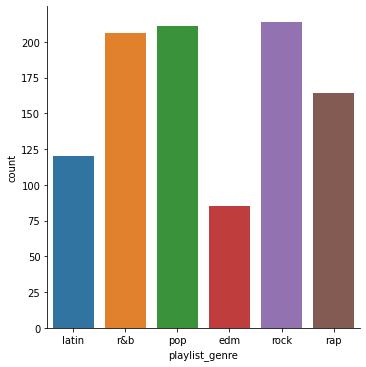

In [ ]:
#check dist of sample out
p = sns.catplot(x="playlist_genre",
                data = samplesongs, kind = "count")
p

#the sample subset seems OK - latin is a bit underrepresented but it only has 2K songs despite being among more popular genres

In [ ]:
#re-set sample dataframe's index since it's now out of order w/random samples pulled
#from orig dataframe

samplesongs.reset_index(drop = True, inplace = True)
samplesongs[:10]

,playlist_genre,lyrics
0,latin,"NA Uh-uh-uh, uh-uh Uh-uh-uh, uh-uh A mí que no..."
1,r&b,"Baby, I want some of your love Your love, your..."
2,r&b,"Yo, after tonight...Don't leave your girl arou..."
3,pop,Mum mum mum mah Mum mum mum mah Mum mum mum ma...
4,edm,Miles of fire I'm losing ground And in the fla...
5,edm,"Don't pause, press play Don't pause, press pla..."
6,rock,You pack your bags and you move to the city Th...
7,rap,"PA, PA, and I keep yelling it But y'all don't ..."
8,rap,Mike Strange Welcome to Our World Turn your CD...
9,rock,Now is the moment I waited for I can't be brok...


In [ ]:
###Clean up, clean up

#1: Remove blank rows if any.
samplesongs.isnull().sum() #shouldn't have any after above cleaning but I'm paranoid
samplesongs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   playlist_genre  1000 non-null   object
 1   lyrics          1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [ ]:
#2: Change all the lyrics text to string data type. 
samplesongs['lyrics'] = samplesongs.lyrics.astype(str)

# NLP - 
Corpus Statistics, Frequent Words and Bigrams

In [ ]:
#import nltk
nltk.download('punkt')
from nltk.probability import FreqDist

freqdist = FreqDist(sum(samplesongs['lyrics'].map(word_tokenize), []))
freqdist.most_common()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[(',', 32253),
 ('I', 20723),
 ('you', 13122),
 ('the', 12763),
 ('me', 8118),
 ('to', 7656),
 ('(', 7540),
 (')', 7538),
 ('a', 7515),
 ("'", 7023),
 ("n't", 6749),
 ('it', 6674),
 ('my', 5372),
 ("'s", 5323),
 ("'m", 4450),
 ('in', 4387),
 ('and', 4195),
 ('on', 3878),
 ('that', 3836),
 ('do', 3653),
 ('?', 3131),
 ('your', 3127),
 ('no', 3050),
 ('of', 2927),
 ('You', 2763),
 ('like', 2746),
 ('up', 2707),
 ('And', 2681),
 ('we', 2610),
 ('be', 2548),
 ('know', 2485),
 ('with', 2444),
 ('for', 2386),
 ('love', 2361),
 ('got', 2255),
 ('na', 2145),
 ('all', 2115),
 ('is', 2076),
 ("'re", 2054),
 ('que', 1879),
 ('just', 1849),
 ('la', 1789),
 ('get', 1736),
 ('this', 1689),
 ('so', 1547),
 ("'ll", 1514),
 ('what', 1478),
 ('yeah', 1451),
 ('go', 1427),
 ('out', 1420),
 ('It', 1386),
 ('But', 1371),
 ('!', 1356),
 ('down', 1278),
 ('can', 1248),
 ('they', 1206),
 ('Oh', 1187),
 ('oh', 1183),
 ('want', 1167),
 ('wan', 1163),
 ('but', 1147),
 ('now', 1141),
 ('baby', 1139),
 ('We', 1122

In [ ]:
#plot of frequent tokens
freqdist.plot(25, cumulative = True, title = 'Frequency Plot of Cumulative Lyrics Token Counts')

NameError: ignored

As with many documents to be analyzed - lots of punctuation marks by count. Since they don't give us much meaning, we'll drop them from analysis in a bit.

In [ ]:
#3: Initial tokenization with Punkt word tokenize

#nltk.download('punkt')

samplesongs['lyrics_tokenized'] = samplesongs['lyrics'].map(word_tokenize)
samplesongs.head()

,playlist_genre,lyrics,lyrics_tokenized
0,latin,"NA Uh-uh-uh, uh-uh Uh-uh-uh, uh-uh A mí que no...","[NA, Uh-uh-uh, ,, uh-uh, Uh-uh-uh, ,, uh-uh, A..."
1,edm,The melody The melody The melody The melody,"[The, melody, The, melody, The, melody, The, m..."
2,pop,If I could be honest I feel like I'm losing yo...,"[If, I, could, be, honest, I, feel, like, I, '..."
3,r&b,"Bitch, I feel like Peppa Pig (oink) Cause I'm ...","[Bitch, ,, I, feel, like, Peppa, Pig, (, oink,..."
4,latin,NA Hay tanto que quiero contarte Hay tanto que...,"[NA, Hay, tanto, que, quiero, contarte, Hay, t..."


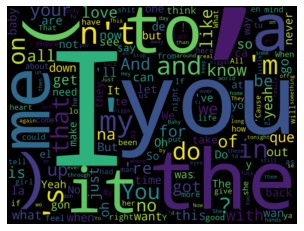

In [ ]:
#so far success!
#let's visualize the non-fully cleaned but lowercase lyrics show so far 
#and then keep cleaning

#4 - wordcloud with all tokens

from wordcloud import WordCloud, STOPWORDS

lyricscloud = dict([(m, n) for m, n in freqdist.items() if len(m) > 0])
 
 #specifying token length > 3 will discard punctuation from wordlcoud
 #(but not remove it yet from dataset)

lyricscloud = WordCloud(width = 1600, height = 1200).generate_from_frequencies(lyricscloud)
 
#plotting the wordcloud
plt.imshow(lyricscloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

The wordcloud above reveals that punctuation appears a lot in lyrics (unsurprisingly) - not a lot of exclamation points as one might suspect. Lots of contractions - indicating less formal language perhaps. 

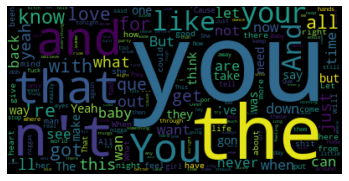

In [ ]:
#5 - Remove Stop words, continue cleaning
#remove stopwords/tokens under 3 characters & see how wordcloud changes

lyricscloud = dict([(m, n) for m, n in freqdist.items() if len(m) > 2])
 
lyricscloud = WordCloud().generate_from_frequencies(lyricscloud)
 
#plotting the wordcloud
plt.imshow(lyricscloud, interpolation="bilinear")
plt.axis('off')
plt.show()

It seems personal relationships dominate even with "I" and words/tokens less than 2 characters removed. "You" overwhelmingly dominates the visual field. The language appears fairly simple/many one-syllable words.

In [ ]:
#re-lowercase and remove punctuation, then retokenize and count
samplesongs.lyrics.isna().sum()

0

In [ ]:
#if needed - force reapply str datatype (colab was being weird)
#samplesongs['lyrics'] = samplesongs['lyrics'].apply(str)
#samplesongs

,playlist_genre,lyrics,lyrics_tokenized
0,latin,"NA Uh-uh-uh, uh-uh Uh-uh-uh, uh-uh A mí que no...","[NA, Uh-uh-uh, ,, uh-uh, Uh-uh-uh, ,, uh-uh, A..."
1,edm,The melody The melody The melody The melody,"[The, melody, The, melody, The, melody, The, m..."
2,pop,If I could be honest I feel like I'm losing yo...,"[If, I, could, be, honest, I, feel, like, I, '..."
3,r&b,"Bitch, I feel like Peppa Pig (oink) Cause I'm ...","[Bitch, ,, I, feel, like, Peppa, Pig, (, oink,..."
4,latin,NA Hay tanto que quiero contarte Hay tanto que...,"[NA, Hay, tanto, que, quiero, contarte, Hay, t..."
...,...,...,...
995,pop,Sé que el instinto me intentó avisar Que conoc...,"[Sé, que, el, instinto, me, intentó, avisar, Q..."
996,r&b,"I was lost in thought, when it all began I was...","[I, was, lost, in, thought, ,, when, it, all, ..."
997,edm,NA Rasputin Rasputin Rasputin Rasputin Rasputi...,"[NA, Rasputin, Rasputin, Rasputin, Rasputin, R..."
998,rap,Hey Dude There's three things that I love in l...,"[Hey, Dude, There, 's, three, things, that, I,..."


In [ ]:
#first - remove punctuation
samplesongs['lyrics'] = samplesongs['lyrics'].str.replace(r'[^\w\s]+', '')
samplesongs['lyrics']

#next - convert to lowercase
samplesongs['lyrics'] = samplesongs['lyrics'].str.lower()
samplesongs['lyrics']

#next - tokenize
samplesongs['lyrics_tokenized'] = samplesongs['lyrics'].map(word_tokenize)
samplesongs['lyrics_tokenized']

0      [na, uhuhuh, uhuh, uhuhuh, uhuh, a, mí, que, n...
1      [baby, i, want, some, of, your, love, your, lo...
2      [yo, after, tonightdont, leave, your, girl, ar...
3      [mum, mum, mum, mah, mum, mum, mum, mah, mum, ...
4      [miles, of, fire, im, losing, ground, and, in,...
                             ...                        
995    [baby, youve, been, so, distant, from, me, lat...
996    [and, baby, let, me, cry, for, you, wont, you,...
997    [scott, storch, all, eyes, on, ya, ask, you, h...
998    [im, an, eclipse, im, a, shootin, star, ima, m...
999    [do, you, have, the, time, to, listen, to, me,...
Name: lyrics_tokenized, Length: 1000, dtype: object

In [ ]:
#this seems OK! there's some nitpicky cleaning we can do 
#but for now - we've got lowercase and punctuation free lyrics
#now just for tokenized lyrics! 

#Since the above steps work - applying to entire 17K Songs dataframe


In [ ]:
#first - remove all lyrics' punctuation
songs['lyrics_clean'] = songs['lyrics'].str.replace(r'[^\w\s]+', '')
songs['lyrics_clean']

0        The trees are singing in the wind The sky blue...
1        NA Yeah Spyderman and Freeze in full effect Uh...
2        I really cant stay Baby its cold outside Ive g...
3        Get up out of my business You dont keep me fro...
4        Hold your breath dont look down keep trying Da...
                               ...                        
17105    NA Sé que hay cosas que me digo Que no tienen ...
17106    Sé que todo te irá bien Y que verás París con ...
17107    NA Gocho Don Don MVP Dale dale Don dale Pa que...
17108    Señoras y señores Damas y perros Llamando a to...
17109    NA Siempre caigo en tu juego no no Te aprovech...
Name: lyrics_clean, Length: 17110, dtype: object

In [ ]:
#next - convert to lowercase
songs['lyrics_clean'] = songs['lyrics'].str.lower()
songs['lyrics_clean']

0        the trees, are singing in the wind the sky blu...
1        na yeah, spyderman and freeze in full effect u...
2        i really can't stay baby it's cold outside i'v...
3        get up out of my business you don't keep me fr...
4        hold your breath, don't look down, keep trying...
                               ...                        
17105    na sé que hay cosas que me digo que no tienen ...
17106    sé que todo te irá bien y que verás parís con ...
17107    na gocho! don, don! (m-v-p) dale, dale don, da...
17108    señoras y señores damas y perros llamando a to...
17109    na siempre caigo en tu juego, no, no te aprove...
Name: lyrics_clean, Length: 17110, dtype: object

# Wordcloud - ALL lyrics

In [ ]:
#now - a frequencydist of ALL the lyrics!
#freqdist = FreqDist(sum(songs['lyrics'].map(word_tokenize), []))

frequent = freqdist.most_common()
frequent

[(',', 32253),
 ('I', 20723),
 ('you', 13122),
 ('the', 12763),
 ('me', 8118),
 ('to', 7656),
 ('(', 7540),
 (')', 7538),
 ('a', 7515),
 ("'", 7023),
 ("n't", 6749),
 ('it', 6674),
 ('my', 5372),
 ("'s", 5323),
 ("'m", 4450),
 ('in', 4387),
 ('and', 4195),
 ('on', 3878),
 ('that', 3836),
 ('do', 3653),
 ('?', 3131),
 ('your', 3127),
 ('no', 3050),
 ('of', 2927),
 ('You', 2763),
 ('like', 2746),
 ('up', 2707),
 ('And', 2681),
 ('we', 2610),
 ('be', 2548),
 ('know', 2485),
 ('with', 2444),
 ('for', 2386),
 ('love', 2361),
 ('got', 2255),
 ('na', 2145),
 ('all', 2115),
 ('is', 2076),
 ("'re", 2054),
 ('que', 1879),
 ('just', 1849),
 ('la', 1789),
 ('get', 1736),
 ('this', 1689),
 ('so', 1547),
 ("'ll", 1514),
 ('what', 1478),
 ('yeah', 1451),
 ('go', 1427),
 ('out', 1420),
 ('It', 1386),
 ('But', 1371),
 ('!', 1356),
 ('down', 1278),
 ('can', 1248),
 ('they', 1206),
 ('Oh', 1187),
 ('oh', 1183),
 ('want', 1167),
 ('wan', 1163),
 ('but', 1147),
 ('now', 1141),
 ('baby', 1139),
 ('We', 1122

In [ ]:
#save the freqdist to csv!
#import csv

freqdist_results = pd.DataFrame(list(freqdist.items()), columns = ["Word","Frequency"])
freqdist_results

,Word,Frequency
0,NA,292
1,Uh-uh-uh,2
2,",",32253
3,uh-uh,7
4,A,436
...,...,...
20421,adding,9
20422,analyze,3
20423,bore,3
20424,whining,3


In [ ]:
# Import Drive API and authenticate.
#from google.colab import drive

# Mount your Drive to the Colab VM.
#drive.mount('/gdrive')

#copy the enormous results to a dataframe - just so don't have to repeat hopefully
#if colab crashes and wipes out my variables for a dozenth time

#with open('/gdrive/My Drive/freqdist.csv', 'w') as f:
#  freqdist_results.to_csv(f)

In [ ]:
#We can now visualize the most frequently occurring words before and after
#stopword removal

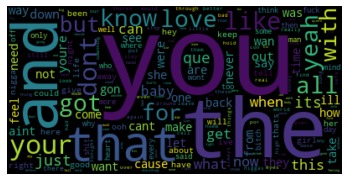

In [ ]:
#wordcloud - ALL lyrics! we'll skip smaller stopwords in this one 
#since we found above

songslyricscloud = dict([(m, n) for m, n in freqdist.items() if len(m) > 2])
 
songslyricscloud = WordCloud().generate_from_frequencies(songslyricscloud)
 
#plotting the wordcloud
plt.imshow(songslyricscloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
songslyricscloud_nsw = dict([(m, n) for m, n in freqdist.items() if len(m) > 3])
 
songslyricscloud_nsw = WordCloud().generate_from_frequencies(songslyricscloud_nsw)
 
#plotting the wordcloud
plt.imshow(songslyricscloud_nsw, interpolation="bilinear")
plt.axis('off')
plt.show()

NameError: ignored

In [ ]:
#plot of the freqdist results - top 25 words - including stop words
songs_word_count_sw = freqdist_results.sort_values(by = "Frequency", ascending = False)

songs_word_count_sw.set_index('Word', inplace = True)

songs_word_count_sw.head()

,Frequency
Word,
",",32253
I,20723
you,13122
the,12763
me,8118


In [ ]:
#some manual cleaning because regex is blowing up colab again...

songs_word_count_sw = songs_word_count_sw.drop([','])
songs_word_count_sw = songs_word_count_sw.drop(['('])
songs_word_count_sw = songs_word_count_sw.drop([')'])
songs_word_count_sw = songs_word_count_sw.drop(['\''])
songs_word_count_sw = songs_word_count_sw.drop(['\'s'])
songs_word_count_sw = songs_word_count_sw.drop(['?'])
songs_word_count_sw = songs_word_count_sw.drop(['\'m'])

In [ ]:
#take the first 25 words for the plot
songs_word_count_sw = songs_word_count_sw[:25]
songs_word_count_sw


,Frequency
Word,
I,20723
you,13122
the,12763
me,8118
to,7656
a,7515
n't,6749
it,6674
my,5372


In [ ]:
#reset index for plottin
songs_word_count_sw = songs_word_count_sw.reset_index(drop=False)
songs_word_count_sw

,Word,Frequency
0,I,20723
1,you,13122
2,the,12763
3,me,8118
4,to,7656
5,a,7515
6,n't,6749
7,it,6674
8,my,5372
9,in,4387


In [ ]:
songs_word_count_sw = songs_word_count_sw.drop(labels=[6], axis=0)

Text(0.5, 1.0, 'Most Frequently Occurring Words (Stopwords Included) - All Lyrics and Genres')

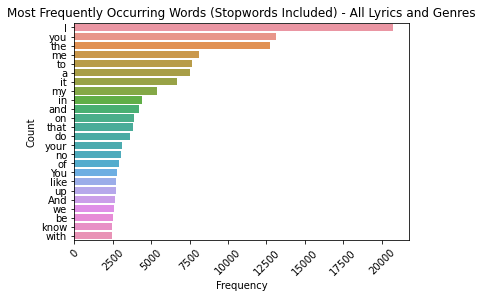

In [ ]:
#the plot!

sns.barplot(data = songs_word_count_sw, x = 'Frequency', y = 'Word', orient='h')
plt.xticks(rotation = 45)
plt.ylabel('Count')
plt.title('Most Frequently Occurring Words (Stopwords Included) - All Lyrics and Genres')

In [ ]:
#repeat the above graph with stop words removed!
songs_word_count_nsw = dict([(m, n) for m, n in freqdist.items() if len(m) > 4])
songs_word_count_nsw = dict(sorted(songs_word_count_nsw.items(), key = lambda item: item[1]))
#songs_word_count_nsw = sorted(songs_word_count_nsw.items(), key=lambda x: x[1], reverse=True)

songs_word_count_nsw = pd.DataFrame(songs_word_count_nsw.items(),  columns = ['Word', 'Count'])
songs_word_count_nsw.sort_values(by = ['Count'], ascending = False)


,Word,Count
15933,never,886
15932,there,800
15931,right,748
15930,about,729
15929,think,682
...,...,...
4667,motto,1
4668,tring,1
4669,submarines,1
4670,wreckin,1


In [ ]:
songs_word_count_nsw = songs_word_count_nsw.sort_values(by = "Count", ascending=False)
songs_word_count_nsw

,Word,Count
15933,never,886
15932,there,800
15931,right,748
15930,about,729
15929,think,682
...,...,...
4671,Treasure,1
4647,fascists,1
4672,Stolen,1
4674,ceilings,1


In [ ]:
#let's take the top 25 words - words < 4 characters not included (most stop words)
songs_word_count_nsw_top25 = songs_word_count_nsw[:26]
songs_word_count_nsw_top25

,Word,Count
15933,never,886
15932,there,800
15931,right,748
15930,about,729
15929,think,682
15928,night,643
15927,could,626
15926,heart,581
15925,nigga,533
15924,still,514


Text(0.5, 1.0, 'Most Frequently Occurring Words (Stopwords Excluded) - All Lyrics and Genres')

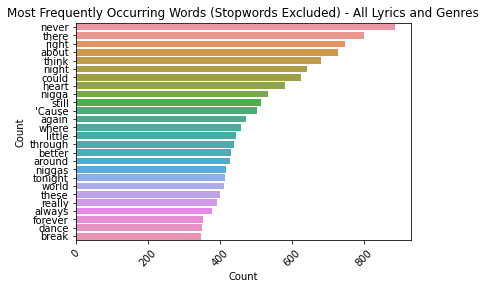

In [ ]:
#plotting the sorted words!

sns.barplot(data = songs_word_count_nsw_top25, x = 'Count', y = 'Word', orient='h')
plt.xticks(rotation = 45)
plt.ylabel('Count')
plt.title('Most Frequently Occurring Words (Stopwords Excluded) - All Lyrics and Genres')

## Frequently Used Words by Genre

In [ ]:
#let's begin separating out genre songs into separate dataframes for ease...
#handy lists from earlier!
genreslist
subgenrelist

array(['hard rock', 'new jack swing', 'neo soul', 'dance pop',
       'urban contemporary', 'big room', 'indie poptimism',
       'gangster rap', 'album rock', 'hip pop', 'post-teen pop', 'trap',
       'southern hip hop', 'electropop', 'tropical',
       'progressive electro house', 'pop edm', 'latin hip hop', 'hip hop',
       'permanent wave', 'classic rock', 'electro house', 'latin pop',
       'reggaeton'], dtype=object)

In [ ]:
#top 3 categories -- hip hop, pop, and rock

#sep hiphop songs
#hh_songs = songs.loc[songs['playlist_subgenre'] == 'hip hop'] 
#hh_songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4099 entries, 3 to 17106
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   track_name                4099 non-null   object  
 1   track_artist              4099 non-null   object  
 2   lyrics                    4099 non-null   object  
 3   track_popularity          4099 non-null   int64   
 4   track_album_name          4099 non-null   object  
 5   track_album_release_date  4099 non-null   object  
 6   playlist_name             4099 non-null   object  
 7   playlist_genre            4099 non-null   object  
 8   playlist_subgenre         4099 non-null   object  
 9   danceability              4099 non-null   float64 
 10  energy                    4099 non-null   float64 
 11  key                       4099 non-null   int64   
 12  loudness                  4099 non-null   float64 
 13  mode                      4099 non-null   int64

In [ ]:
#pull out pop songs
options = ("latin pop", "electropop", "post-teen pop", "dance pop", "pop edm", "hip pop")
pop_songs = songs.loc[songs['playlist_subgenre'].isin(options)]
pop_songs.info()

In [ ]:
#pull out rock songs
options = ("hard rock", "classic rock")
rock_songs = songs.loc[songs['playlist_subgenre'].isin(options)]
#rock_songs.info()
rock_songs

,track_name,track_artist,lyrics,track_popularity,track_album_name,track_album_release_date,playlist_name,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,language,lyrics_clean
0,I Feel Alive,Steady Rollin,"The trees, are singing in the wind The sky blu...",28,Love & Loss,2017-11-21,Hard Rock Workout,rock,hard rock,0.303,0.880,9,-4.739,1,0.0442,0.011700,0.009940,0.3470,0.404,135.225,373512,en,"the trees, are singing in the wind the sky blu..."
36,Now That We're Dead,Metallica,"When darkness falls, may it be That we should ...",50,Hardwired…To Self-Destruct,2016-11-18,Hard Rock Workout,rock,hard rock,0.566,0.951,2,-3.591,1,0.0464,0.000101,0.103000,0.2660,0.345,128.304,419075,en,"when darkness falls, may it be that we should ..."
42,Talk Dirty To Me,Poison,You know I never I never seen you look so good...,54,Look What The Cat Dragged In,1986-01-01,"Classic Rock 70s 80s 90s, Rock Classics - 70s ...",rock,classic rock,0.507,0.804,11,-13.267,1,0.0440,0.021100,0.002480,0.3810,0.708,157.996,223960,en,you know i never i never seen you look so good...
47,Rattle Your Cage,Skrizzly Adams,Well I know you've been talking somebody When ...,44,Young Man,2019-11-15,Supernatural Classic Rock,rock,classic rock,0.583,0.565,1,-8.318,1,0.1230,0.027000,0.000000,0.0908,0.498,179.874,209972,en,well i know you've been talking somebody when ...
59,Who Are You,The Who,"Who are you? Who, who, who, who? Who are you? ...",12,Who Are You,1978-08-18,Classic Rock Drive,rock,classic rock,0.653,0.631,9,-11.334,1,0.0461,0.299000,0.002650,0.0627,0.516,156.320,381627,en,"who are you? who, who, who, who? who are you? ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15344,Glory Days,Bruce Springsteen,Yeah Uh Wooh Huh I had a friend was a big base...,1,Greatest Hits,2009-06-01,HARD ROCK CAFE,rock,hard rock,0.568,0.885,9,-10.485,1,0.0311,0.150000,0.000000,0.0502,0.975,117.447,259267,en,yeah uh wooh huh i had a friend was a big base...
15354,Driftin' Blues,Charles Brown,"Well, I'm drifting and I'm drifting Like a shi...",0,Driftin' Blues,1963-12-14,Blues Rock,rock,classic rock,0.342,0.239,10,-15.682,1,0.0394,0.853000,0.000029,0.0691,0.494,200.639,239813,en,"well, i'm drifting and i'm drifting like a shi..."
15357,Don't Cry (Original),Guns N' Roses,"Talk to me softly, there's something in your e...",2,Greatest Hits,2004-01-01,80s / Classic Rock,rock,classic rock,0.292,0.661,11,-7.478,1,0.0373,0.003160,0.003550,0.0891,0.260,124.729,284093,en,"talk to me softly, there's something in your e..."
15374,Crocodile Rock,Elton John,I remember when rock was young Me and Susie ha...,3,Elton John's Greatest Hits,1990-01-01,70's Classic Rock,rock,classic rock,0.625,0.665,4,-11.681,0,0.0375,0.078600,0.000014,0.0470,0.970,150.275,235067,en,i remember when rock was young me and susie ha...


In [ ]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
samplesongs['genre_coded'] = LE.fit_transform(samplesongs['playlist_genre'])
samplesongs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   playlist_genre    1000 non-null   object
 1   lyrics            1000 non-null   object
 2   lyrics_tokenized  1000 non-null   object
 3   genre_coded       1000 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [ ]:
vectorizer = CountVectorizer()

matrix = vectorizer.fit_transform(samplesongs['lyrics_tokenized'])
matrix

AttributeError: ignored

## Using Lyrics Sentiment to Determine Song Popularity

  - Sentiment based regressor (VADER)

  

In [ ]:
#!pip install vaderSentiment
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


True

In [ ]:
#instantiate the analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

samplesongs['scores'] = samplesongs['lyrics'].apply(lambda lyrics: sentiment_analyzer.polarity_scores(lyrics))

#verify results
samplesongs.info()
samplesongs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   playlist_genre    1000 non-null   object
 1   lyrics            1000 non-null   object
 2   lyrics_tokenized  1000 non-null   object
 3   genre_coded       1000 non-null   int64 
 4   scores            1000 non-null   object
dtypes: int64(1), object(4)
memory usage: 39.2+ KB


,playlist_genre,lyrics,lyrics_tokenized,genre_coded,scores
0,latin,na uhuhuh uhuh uhuhuh uhuh a mí que no me trai...,"[na, uhuhuh, uhuh, uhuhuh, uhuh, a, mí, que, n...",1,"{'neg': 0.018, 'neu': 0.731, 'pos': 0.252, 'co..."
1,r&b,baby i want some of your love your love your l...,"[baby, i, want, some, of, your, love, your, lo...",3,"{'neg': 0.02, 'neu': 0.664, 'pos': 0.316, 'com..."
2,r&b,yo after tonightdont leave your girl around me...,"[yo, after, tonightdont, leave, your, girl, ar...",3,"{'neg': 0.043, 'neu': 0.66, 'pos': 0.297, 'com..."
3,pop,mum mum mum mah mum mum mum mah mum mum mum ma...,"[mum, mum, mum, mah, mum, mum, mum, mah, mum, ...",2,"{'neg': 0.029, 'neu': 0.775, 'pos': 0.195, 'co..."
4,edm,miles of fire im losing ground and in the flas...,"[miles, of, fire, im, losing, ground, and, in,...",0,"{'neg': 0.097, 'neu': 0.803, 'pos': 0.1, 'comp..."
...,...,...,...,...,...
995,pop,baby youve been so distant from me lately and ...,"[baby, youve, been, so, distant, from, me, lat...",2,"{'neg': 0.11, 'neu': 0.748, 'pos': 0.143, 'com..."
996,pop,and baby let me cry for you wont you see i liv...,"[and, baby, let, me, cry, for, you, wont, you,...",2,"{'neg': 0.297, 'neu': 0.671, 'pos': 0.032, 'co..."
997,rap,scott storch all eyes on ya ask you how your w...,"[scott, storch, all, eyes, on, ya, ask, you, h...",4,"{'neg': 0.092, 'neu': 0.87, 'pos': 0.038, 'com..."
998,r&b,im an eclipse im a shootin star ima make you c...,"[im, an, eclipse, im, a, shootin, star, ima, m...",3,"{'neg': 0.108, 'neu': 0.481, 'pos': 0.41, 'com..."


In [ ]:
#traverse through each row of lyrics and append the scores
samplesongs['compound']  = samplesongs['scores'].apply(lambda score_dict: score_dict['compound'])
samplesongs

,playlist_genre,lyrics,lyrics_tokenized,scores,compound
0,latin,na uhuhuh uhuh uhuhuh uhuh a mí que no me trai...,"[na, uhuhuh, uhuh, uhuhuh, uhuh, a, mí, que, n...","{'neg': 0.018, 'neu': 0.731, 'pos': 0.252, 'co...",0.9977
1,edm,the melody the melody the melody the melody,"[the, melody, the, melody, the, melody, the, m...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
2,pop,if i could be honest i feel like im losing you...,"[if, i, could, be, honest, i, feel, like, im, ...","{'neg': 0.02, 'neu': 0.591, 'pos': 0.388, 'com...",0.9994
3,r&b,bitch i feel like peppa pig oink cause im head...,"[bitch, i, feel, like, peppa, pig, oink, cause...","{'neg': 0.173, 'neu': 0.622, 'pos': 0.206, 'co...",0.6093
4,latin,na hay tanto que quiero contarte hay tanto que...,"[na, hay, tanto, que, quiero, contarte, hay, t...","{'neg': 0.055, 'neu': 0.945, 'pos': 0.0, 'comp...",-0.8481
...,...,...,...,...,...
995,pop,sé que el instinto me intentó avisar que conoc...,"[sé, que, el, instinto, me, intentó, avisar, q...","{'neg': 0.079, 'neu': 0.921, 'pos': 0.0, 'comp...",-0.9686
996,r&b,i was lost in thought when it all began i was ...,"[i, was, lost, in, thought, when, it, all, beg...","{'neg': 0.061, 'neu': 0.63, 'pos': 0.309, 'com...",0.9993
997,edm,na rasputin rasputin rasputin rasputin rasputi...,"[na, rasputin, rasputin, rasputin, rasputin, r...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
998,rap,hey dude theres three things that i love in li...,"[hey, dude, theres, three, things, that, i, lo...","{'neg': 0.137, 'neu': 0.77, 'pos': 0.093, 'com...",-0.9908


# Applying to entire set of lyrics

In [ ]:
#awesome! it works - so we will repeat on entire Songs dataframe

In [ ]:
#sentiment analysis
songs['scores'] = songs['lyrics'].apply(lambda lyrics: sentiment_analyzer.polarity_scores(lyrics))

In [ ]:
#verify results
songs.head()

,track_name,track_artist,lyrics,track_popularity,track_album_name,track_album_release_date,playlist_name,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,language,lyrics_clean,scores
0,I Feel Alive,Steady Rollin,"The trees, are singing in the wind The sky blu...",28,Love & Loss,2017-11-21,Hard Rock Workout,rock,hard rock,0.303,0.880,9,-4.739,1,0.0442,0.01170,0.00994,0.3470,0.404,135.225,373512,en,"the trees, are singing in the wind the sky blu...","{'neg': 0.036, 'neu': 0.67, 'pos': 0.294, 'com..."
1,Poison,Bell Biv DeVoe,"NA Yeah, Spyderman and Freeze in full effect U...",0,Gold,2005-01-01,"Back in the day - R&B, New Jack Swing, Swingbe...",r&b,new jack swing,0.845,0.652,6,-7.504,0,0.2160,0.00432,0.00723,0.4890,0.650,111.904,262467,en,"na yeah, spyderman and freeze in full effect u...","{'neg': 0.075, 'neu': 0.766, 'pos': 0.159, 'co..."
2,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,I really can't stay Baby it's cold outside I'v...,41,CeeLo's Magic Moment,2012-10-29,Christmas Soul,r&b,neo soul,0.425,0.378,5,-5.819,0,0.0341,0.68900,0.00000,0.0664,0.405,118.593,243067,en,i really can't stay baby it's cold outside i'v...,"{'neg': 0.093, 'neu': 0.752, 'pos': 0.155, 'co..."
3,Dumb Litty,KARD,Get up out of my business You don't keep me fr...,65,KARD 2nd Digital Single ‘Dumb Litty’,2019-09-22,K-Party Dance Mix,pop,dance pop,0.760,0.887,9,-1.993,1,0.0409,0.03700,0.00000,0.1380,0.240,130.018,193160,en,get up out of my business you don't keep me fr...,"{'neg': 0.363, 'neu': 0.586, 'pos': 0.051, 'co..."
4,Soldier,James TW,"Hold your breath, don't look down, keep trying...",70,Chapters,2019-04-26,urban contemporary,r&b,urban contemporary,0.496,0.639,6,-6.157,1,0.0550,0.28000,0.00000,0.0975,0.305,147.764,224720,en,"hold your breath, don't look down, keep trying...","{'neg': 0.137, 'neu': 0.687, 'pos': 0.175, 'co..."


In [ ]:
#cycle through each row of lyrics, append the compound sentiment scores to Songs dataframe
songs['compound']  = songs['scores'].apply(lambda score_dict: score_dict['compound'])
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17110 entries, 0 to 17109
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   track_name                17110 non-null  object  
 1   track_artist              17110 non-null  object  
 2   lyrics                    17110 non-null  object  
 3   track_popularity          17110 non-null  int64   
 4   track_album_name          17110 non-null  object  
 5   track_album_release_date  17110 non-null  object  
 6   playlist_name             17110 non-null  object  
 7   playlist_genre            17110 non-null  object  
 8   playlist_subgenre         17110 non-null  object  
 9   danceability              17110 non-null  float64 
 10  energy                    17110 non-null  float64 
 11  key                       17110 non-null  int64   
 12  loudness                  17110 non-null  float64 
 13  mode                      17110 non-null  int6

In [ ]:
#what's the compound scoring looking? by genre
songs_sent_genre = songs.groupby('playlist_genre')['compound'].describe()
songs_sent_genre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, edm to rock
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   count   6 non-null      float64
 1   mean    6 non-null      float64
 2   std     6 non-null      float64
 3   min     6 non-null      float64
 4   25%     6 non-null      float64
 5   50%     6 non-null      float64
 6   75%     6 non-null      float64
 7   max     6 non-null      float64
dtypes: float64(8)
memory usage: 432.0+ bytes


TypeError: ignored

In [ ]:
#what's the compound scoring looking like by subgenre?
songs_sent_subgenre = songs.groupby('playlist_subgenre')['compound'].describe()
songs_sent_subgenre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, album rock to urban contemporary
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   count   24 non-null     float64
 1   mean    24 non-null     float64
 2   std     24 non-null     float64
 3   min     24 non-null     float64
 4   25%     24 non-null     float64
 5   50%     24 non-null     float64
 6   75%     24 non-null     float64
 7   max     24 non-null     float64
dtypes: float64(8)
memory usage: 1.7+ KB


Text(0, 0.5, 'Mean Sentiment Score')

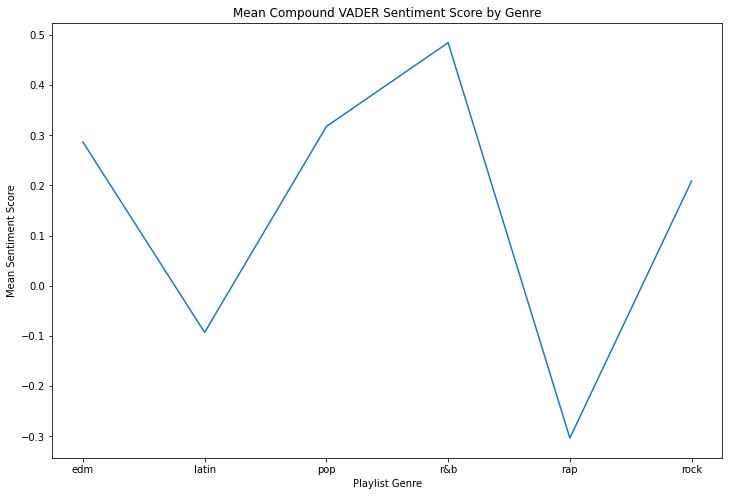

In [ ]:
songs_sent_genre_plot = songs_sent_genre[['mean']]
songs_sent_genre_plot 

dims = (12,8)
fig, ax = pyplot.subplots(figsize=dims)

sns.lineplot(data = songs_sent_genre_plot, legend = False)
plt.title("Mean Compound VADER Sentiment Score by Genre")
plt.xlabel("Playlist Genre")
plt.ylabel("Mean Sentiment Score")

Text(0, 0.5, 'Mean Sentiment Score')

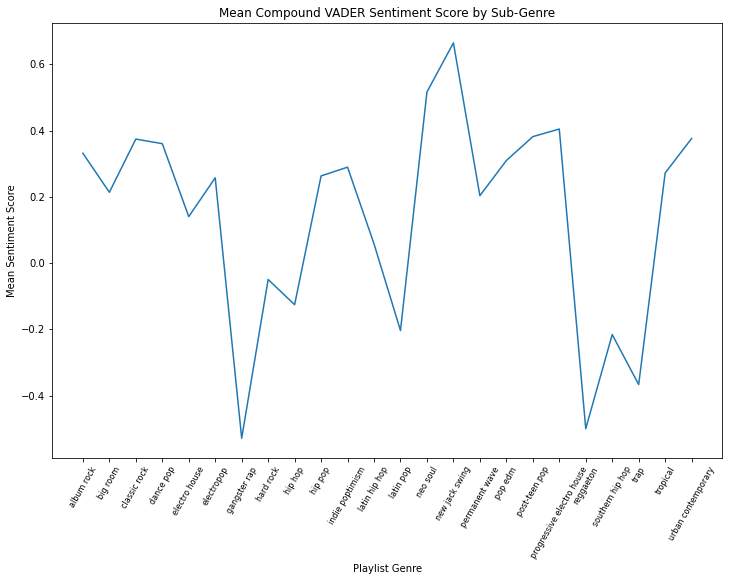

In [ ]:
from matplotlib import pyplot

songs_sent_subgenre_plot = songs_sent_subgenre[['mean']]
songs_sent_subgenre_plot

dims = (12,8)
fig, ax = pyplot.subplots(figsize=dims)

sns.lineplot(data = songs_sent_subgenre_plot, legend=False)
plt.title("Mean Compound VADER Sentiment Score by Sub-Genre")
plt.xlabel("Playlist Genre")
plt.xticks(rotation = 60, fontsize = 8)
plt.ylabel("Mean Sentiment Score")

In [ ]:
#and now - append the other sentiment scores to Songs dataframe
songs['pos_scores']  = songs['scores'].apply(lambda score_dict: score_dict['positive'])
songs.info()

# Plot - Average Compound Sentiment by Genre + Subgenre

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


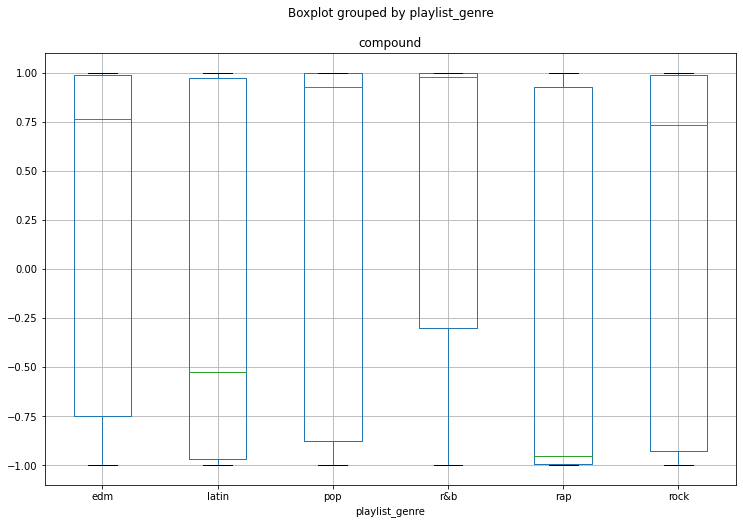

In [ ]:
#a boxplot of sentiment scores (Compound) x playlist genre
songs.boxplot(by = 'playlist_genre', column = 'compound', figsize=(12,8), )
plt.title('Boxplot: Compound VADER Sentiment Scores by Genre')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24]),
 <a list of 24 Text major ticklabel objects>)

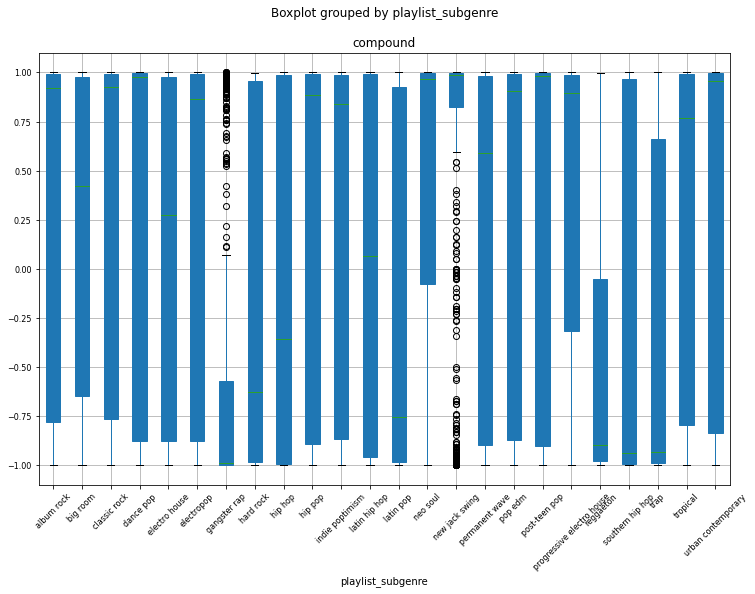

In [ ]:
#a boxplot of sentiment scores (Compound) x playlist subgenre
#and hopefully fill with colorblind friendly colors
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

bplot = songs.boxplot(by = 'playlist_subgenre', column = 'compound', 
              figsize=(12,8), fontsize = 8, patch_artist = CB_color_cycle)
plt.xticks(rotation = 45)


## Now that sentiment scores are added - repeating *corrplot*

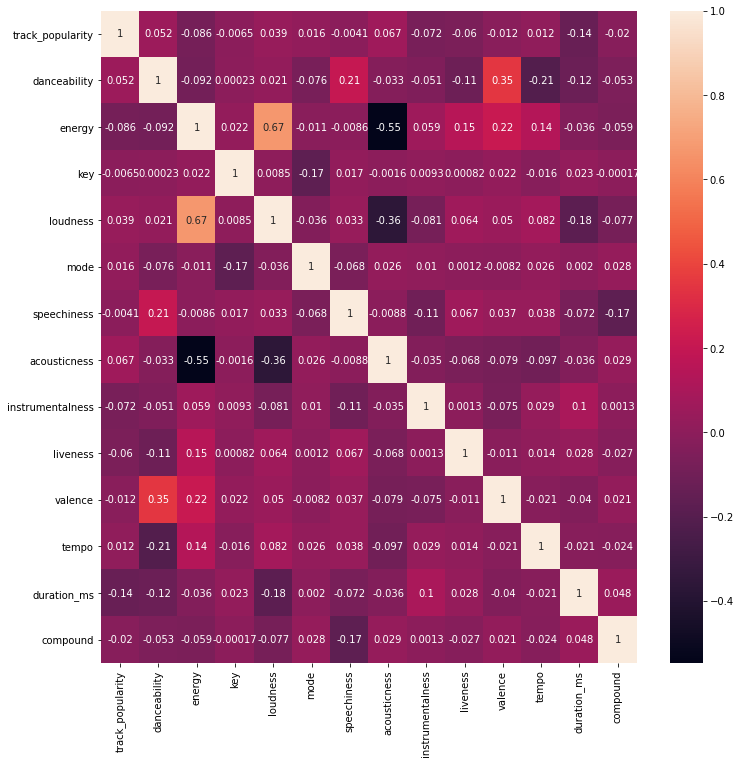

In [ ]:
#Overall correlations: a detailed seaborn correlation plot
plt.figure(figsize = (12,12))
sns.heatmap(songs.corr(), annot = True)

In [ ]:
#split out positive and negative sentiments and repeat corr map

songs['sentiment'] = songs['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')
songs.head()

,track_name,track_artist,lyrics,track_popularity,track_album_name,track_album_release_date,playlist_name,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,language,scores,compound,sentiment
0,I Feel Alive,Steady Rollin,the trees are singing in the wind the sky blue...,28,Love & Loss,2017-11-21,Hard Rock Workout,rock,hard rock,0.303,0.880,9,-4.739,1,0.0442,0.01170,0.00994,0.3470,0.404,135.225,373512,en,"{'neg': 0.036, 'neu': 0.673, 'pos': 0.291, 'co...",0.9860,pos
1,Poison,Bell Biv DeVoe,na yeah spyderman and freeze in full effect uh...,0,Gold,2005-01-01,"Back in the day - R&B, New Jack Swing, Swingbe...",r&b,new jack swing,0.845,0.652,6,-7.504,0,0.2160,0.00432,0.00723,0.4890,0.650,111.904,262467,en,"{'neg': 0.234, 'neu': 0.646, 'pos': 0.12, 'com...",-0.9970,neg
2,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,i really cant stay baby its cold outside ive g...,41,CeeLo's Magic Moment,2012-10-29,Christmas Soul,r&b,neo soul,0.425,0.378,5,-5.819,0,0.0341,0.68900,0.00000,0.0664,0.405,118.593,243067,en,"{'neg': 0.095, 'neu': 0.796, 'pos': 0.11, 'com...",0.3537,pos
3,Dumb Litty,KARD,get up out of my business you dont keep me fro...,65,KARD 2nd Digital Single ‘Dumb Litty’,2019-09-22,K-Party Dance Mix,pop,dance pop,0.760,0.887,9,-1.993,1,0.0409,0.03700,0.00000,0.1380,0.240,130.018,193160,en,"{'neg': 0.369, 'neu': 0.58, 'pos': 0.051, 'com...",-0.9993,neg
4,Soldier,James TW,hold your breath dont look down keep trying da...,70,Chapters,2019-04-26,urban contemporary,r&b,urban contemporary,0.496,0.639,6,-6.157,1,0.0550,0.28000,0.00000,0.0975,0.305,147.764,224720,en,"{'neg': 0.134, 'neu': 0.656, 'pos': 0.211, 'co...",0.9879,pos


In [ ]:
#create a new dataframe of just genre/compound score and popularity/compound score (regression)

In [ ]:
#first - map genres categories to colors

ML Models - Sentiment x Genre/Subgenre, Sentiment x Popularity

In [ ]:
#remove the labels before clustering

songs_labels = lyrics_popularity.loc[ : , 'track_popularity']
songs_pop = lyrics_popularity.loc[ : , 'lyrics']

songs_pop = songs_pop.to_frame()

songs_pop.describe()

In [ ]:
#kmeans contd

#Frequency vectorizer
vect_freq = CountVectorizer(input="content", max_features = 50000)

#Fit the Frequency Vect object to the data
transf_freq = vect_freq.fit_transform(samplesongs.lyrics_tokenized)
transf_freq_colnames = vect_freq.get_feature_names() 
transf_freq_DF = pd.DataFrame(transf_freq.toarray(), columns = transf_freq_colnames )

#add back labels, if ready, else leave off
#transf_freq_DF_.insert(loc = 0 , column ='Label', value = DF_labels)

Regression - Sentiment x Genre

In [ ]:
#vectorizing/tokenizing lyrics

vectorizer = CountVectorizer()

matrix = vectorizer.fit_transform([text])
matrix

counts = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names())
counts

KNN

SVM

NN

Code References and Sources

In [ ]:
#misc sources

#https://matplotlib.org/3.1.0/tutorials/text/text_props.html#text-with-non-latin-glyphs
#https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92 
#https://www.nltk.org/book/ch01.html
#https://stackoverflow.com/questions/39880627/in-pandas-how-to-delete-rows-from-a-data-frame-based-on-another-data-frame
#https://stackoverflow.com/questions/53898836/export-dataframe-as-csv-file-from-google-colab-to-google-drive/60733479
#https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664 
#https://gist.github.com/thriveth/8560036 <- colorblind colors list
#https://predictivehacks.com/how-to-run-sentiment-analysis-in-python-using-vader/ 
#https://matplotlib.org/stable/gallery/statistics/boxplot_color.html